# Workshop 1: Analyzing connectomics datasets: V1dd

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<b> Electron Microscopy (EM) data enables morphological reconstruction of neurons and detection of their synaptic connectivity </b>. The V1dd dataset </a> is one of the largest datasets volume EM datasets currently available, and spans all layers of visual cortex. We will be using this dataset to query the connectivity between the excitatory neurons in the visual cortex. 

<ol> The exercises will cover: 
    <li>Reconstructions of individual neurons</li>
    <li>Connectivity of individual neurons</li>
    <li>Connectivity of specific cell types</li>
    <li>Connection probability as a function of distance</li>
    <li>Connectivity by connection type (spine, soma, shaft)</li>
</ol>

    
<em> Note on data access: </em> To make our lifes easier, we already queried the most of the data needed for this exercise from the database. We have made it available as versioned files that can be read with pandas. The entire dataset is hosted using the <a href=https://caveconnectome.github.io/sections/cave_overview.html> Connectome Annotation Versioning Engine (CAVE) </a>. A separate notebook shows how to use CAVE to generate the files used in this notebook. 
    
    
</div>

In [1]:
mat_version = 1169

import os
import sys

HOME = os.path.expanduser("~")
# data_dir = f"{HOME}/SWDB_2025_Connectomics/data/{mat_version}"

# NOTE: adjust for your system
data_dir = f"{HOME}/code/swdb/SWDB_2025_Connectomics/data/{mat_version}"
utils_dir = f"{HOME}/code/swdb/SWDB_2025_Connectomics/code/utils"

sys.path.append(utils_dir)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<b> The CAVEclient</b> is a python library that facilitates communication with a CAVE system. For convenience, we also use the package <b>skeleton_plot</b> which handles rendering the precomputed skeletons. Both packages can be installed with pip.
    
</div>

In [2]:
import caveclient
import skeleton_plot as skelplot

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<b> CAVE account setup </b>

<p>In order to manage server traffic, every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. The CAVE infrastructure can be read about in <a href='https://www.biorxiv.org/content/10.1101/2023.07.26.550598v1'>more detail on our preprint</a>. The MICrONS data is publicly available which means that no extra permissions need to be given to a new user account to access the data. Bulk downloads of some static data are also available without an account on <a href='https://microns-explorer.org/'> MICrONs Explorer</a>.

<b> A Google account (or Google-enabled account) is required to create a CAVE account.

<p> Go to: <a href=https://global.daf-apis.com/auth/api/v1/user/token> https://global.daf-apis.com/auth/api/v1/user/token </a>to view a list of your existing tokens
<p> If you have never made a token before: 
<ol>
  <li>go here: <a href=https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public>https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public</a> to accept terms of service</li>
  <li>then go here <a href=https://global.daf-apis.com/auth/api/v1/create_token> https://global.daf-apis.com/auth/api/v1/create_token</a> to create a new token.</li>
</ol>

</div>

In [3]:
# my_token = "PASTE_TOKEN_HERE"
# client = caveclient.CAVEclient("minnie65_public", auth_token=my_token)
client = caveclient.CAVEclient("v1dd")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<p>If you are running this on your local machine rather than colab, you may also store the token on your machine. This makes future access easier as you do not have to specify the token.

</div>

In [4]:
# client.auth.save_token(token=my_token, overwrite=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Proofreading and data quality

**NEEDS REWRITE FOR V1DD**

Understanding this variablity in data quality is critical when interpretting the MICrONS data.

Automated segmentation of neuronal processes in dense EM imaging is challenging at the size of entire neurons, which can have millimeters of axons and dendrites. The automated segmentation algorithms used in the EM data for this project are not perfect, and so proofreading is necessary to obtain accurate reconstructions of a cell and confidence in the connectivity

In the MICrONS dataset, the general rule is that dendrites onto cells with a cell body are sufficiently proofread to trust synaptic connections onto a cell. Axons on the other hand require so much proofreading that only ~1,650 cells have proofread axons.

Axon and dendrite compartment status are marked separately, as proofreading effort was applied differently to the different compartments in some cells.  In all cases, a status of `TRUE` indicates that false merges have been comprehensively removed, and the compartment is at least ‘clean’. Consult the ‘strategy’ column if completeness of the compartment is relevant to your  research.

Some cells were extended to different degrees of completeness, or with different research goals in mind. This is denoted by 'strategy_axon', which may be one of:

<ul>
    <li>none: No cleaning, and no extension, and status is `FALSE`. </li>
    <li>axon_partially_extended: The axon was extended outward from the soma, following each branch to its termination. Output synapses represent a sampling of potential partners. </li>
    <li>axon_interareal: The axon was extended with a preference for branches that projected to other brain areas. Some axon branches were fully extended, but local connections may be incomplete. Output synapses represent a sampling of potential partners. </li>
    <li>axon_fully_extended: Axon was extended outward from the soma, following each branch to its termination. After initial extension, every endpoint was identified, manually inspected, and extended again if possible. Output synapses represent a largely complete sampling of partners.. </li>
</ul>

<b> For this workshop, we treat all cells with at least `axon_partially_extended` as equally trustworth.</b> This may not be a safe assumption for all analysis, and we are happy to provide more guidance depending on the research question.
    
</div>

In [5]:
neuron_soma_df = client.materialize.query_table("neurons_soma_model")
axon_proof_df = client.materialize.query_table(
    "proofreading_status_and_strategy",
    filter_in_dict={"strategy_axon": ["axon_fully_extended"]},
)
single_soma_df = client.materialize.query_view(
    "single_somas", split_positions=True, desired_resolution=[1, 1, 1]
)

dendrite_proof_root_ids = np.array(single_soma_df["pt_root_id"])
dendrite_proof_root_ids = dendrite_proof_root_ids[
    np.isin(dendrite_proof_root_ids, neuron_soma_df["pt_root_id"])
]
axon_proof_root_ids = np.array(axon_proof_df["pt_root_id"])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Synapse information

**NEEDS REWRITE FOR V1DD**

While synapses are stored as any other CAVE table in the database, in this case `synapses_pni_2`, this table is much larger than any other table at more than <b>337 million rows</b>, and it works best when queried in a directed way.

For today's workshop we have collected all of the input and output synapses for the proofread cells in version 1300. When accessing CAVE, the `synapse_query()` function allows you to query the synapse table in a more convenient way than most other tables. In particular, the pre_ids and post_ids let you specify which root id (or collection of root ids) you want to query, with pre_ids indicating the collection of presynaptic neurons and post_ids the collection of postsynaptic neurons.


Note that synapse queries always return the list of every synapse between the neurons in the query, even if there are multiple synapses between the same pair of neurons.

A common pattern to generate a list of connections between unique pairs of neurons is to group by the root ids of the presynaptic and postsynaptic neurons and then count the number of synapses between them. 
    
    
</div>

In [6]:
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather"
)

In [7]:
syn_df.shape

(8190075, 13)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Neuron morphology: plotting skeletons
    
</div>

In [8]:
skel_color_map = {3: "firebrick", 4: "salmon", 2: "steelblue", 1: "olive"}


def plot_skeleton(sk_d: dict, plot_soma=True, ax=None):
    """Plots a skeleton.

    Args:
        sk: skeleton dict as returned from CAVEclient

    Returns:
        ax: plot axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 10), dpi=150)

    skelplot.plot_tools.plot_verts(
        np.array(sk_d["vertices"]),
        np.array(sk_d["edges"]),
        radius=np.array(sk_d["radius"]) / 1000 * 1,
        ax=ax,
        skel_colors=sk_d["compartment"],
        title="",
        skel_alpha=1.0,
        line_width=5,
        x="x",
        y="y",
        plot_soma=plot_soma,
        soma_node=sk_d["root"],
        color="darkslategray",
        soma_size=120,
        invert_y=True,
        skel_color_map=skel_color_map,
        x_min_max=None,
        y_min_max=None,
        capstyle="round",
        joinstyle="round",
    )

    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axis("off")

    return ax

In [9]:
# select from the cells which are fully extended
root_id = axon_proof_root_ids[1]

# Query the skeleton from CAVEclient
sk_d = client.skeleton.get_skeleton(root_id, output_format="dict")

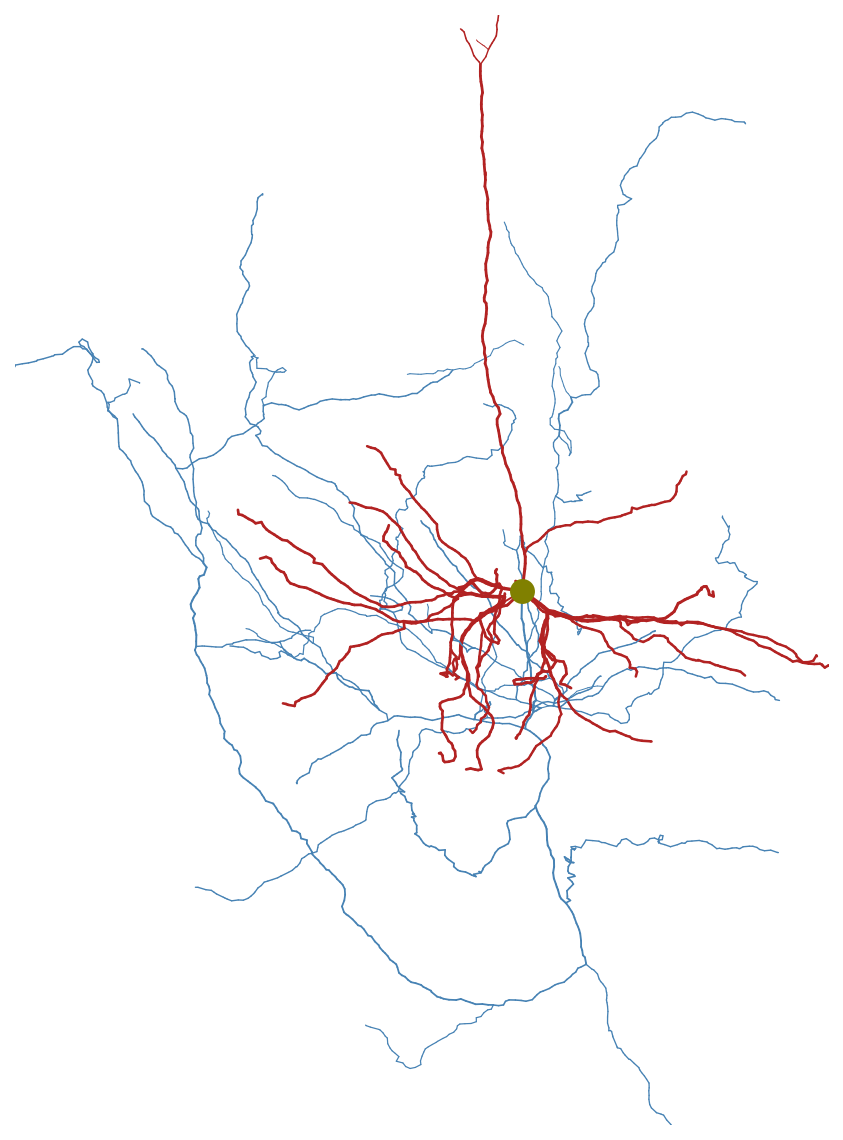

In [10]:
# Plot skeleton in 2D
ax = plot_skeleton(sk_d)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Neuroglancer session goes here


[Link]
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Neuron morphology & synapses
    
</div>

In [11]:
def filter_synapse_table(
    synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None
):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


In [12]:
pre_syns = filter_synapse_table(syn_df, pre_root_ids=[root_id])

In [13]:
pre_syns.head(5)

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id
133,402558233,839602.9,564646.7,228735.0,839515.6,565160.8,229410.0,839699.9,565034.7,229095.0,3881,864691132534315610,864691132726874269
207,292446107,675478.9,569525.8,361440.0,675333.4,569700.4,361125.0,675469.2,569603.4,361305.0,1082,864691132534315610,864691132620269499
380,438169048,865899.6,475571.6,202005.0,865725.0,476095.4,202230.0,865695.9,475872.3,202005.0,5146,864691132534315610,864691132569299996
398,409065816,843327.7,769995.7,336240.0,843395.6,770277.0,336420.0,843405.3,770315.8,336285.0,1694,864691132534315610,864691133066825032
469,397169708,811715.4,751885.8,267750.0,811715.4,751730.6,267525.0,811763.9,751720.9,267750.0,1664,864691132534315610,864691132959793255


<Axes: xlabel='ctr_pt_position_x', ylabel='ctr_pt_position_y'>

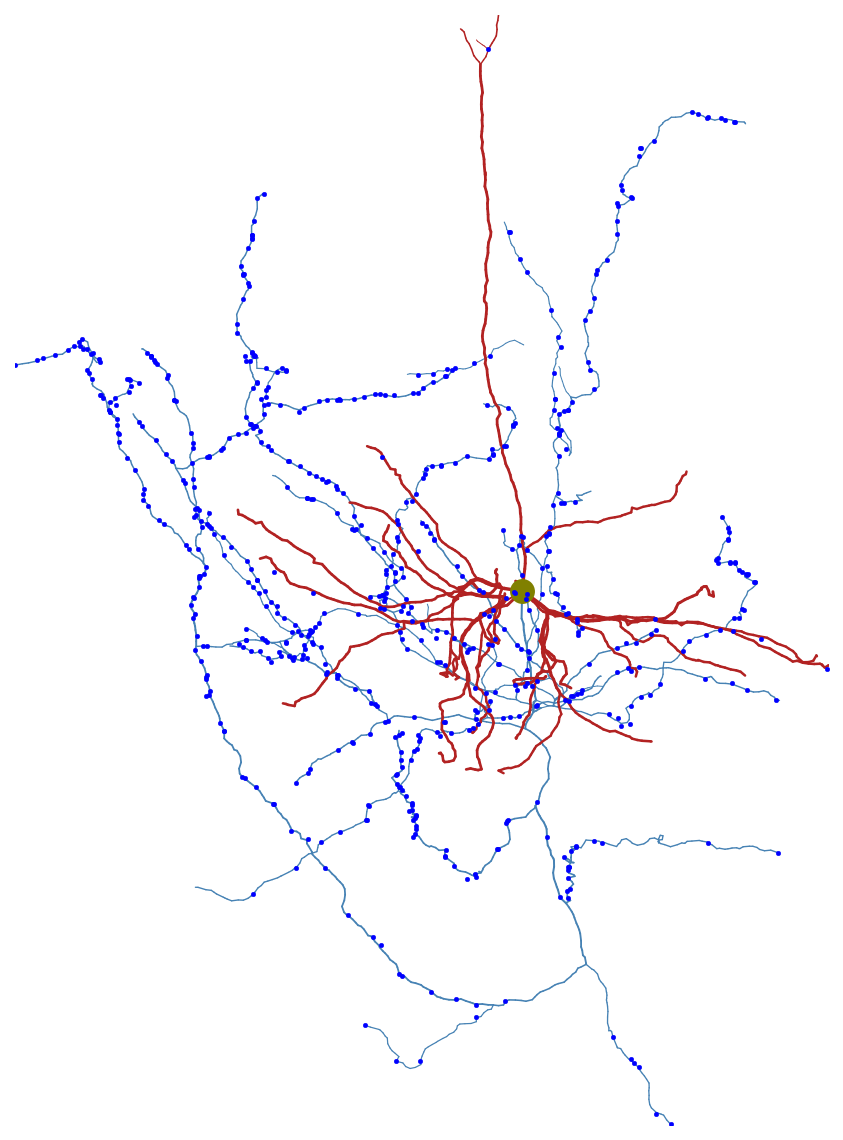

In [14]:
# Plot your skeleton and overlay synapses
ax = plot_skeleton(sk_d)

sns.scatterplot(
    data=pre_syns,
    x="ctr_pt_position_x",
    y="ctr_pt_position_y",
    s=5,
    color="b",
    ax=ax,
    edgecolor=None,
    zorder=100,
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1:</b> Use the filter function above to create a dataframe of all postsynaptic synapses and create a version of the plot above that includes these postsynaptic synapses. 
    
</div>

In [15]:
# Select the synapses where your root_id is postsynaptic ('downstream'); the inputs to your cell
post_syns = filter_synapse_table(syn_df, post_root_ids=[root_id])

<Axes: xlabel='ctr_pt_position_x', ylabel='ctr_pt_position_y'>

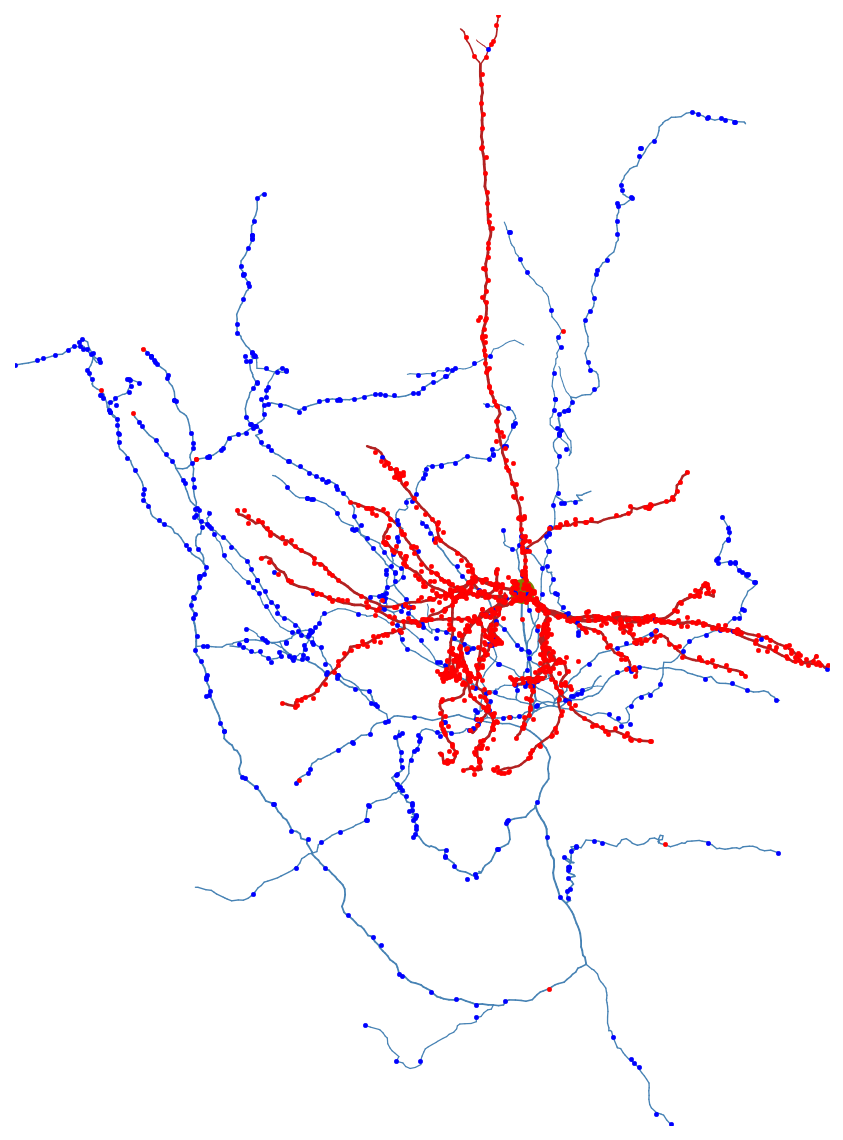

In [16]:
# Plot skeleton with input and output synapses
ax = plot_skeleton(sk_d)

sns.scatterplot(
    data=pre_syns,
    x="ctr_pt_position_x",
    y="ctr_pt_position_y",
    s=5,
    color="b",
    ax=ax,
    edgecolor=None,
    zorder=100,
)

sns.scatterplot(
    data=post_syns,
    x="ctr_pt_position_x",
    y="ctr_pt_position_y",
    s=5,
    color="r",
    ax=ax,
    edgecolor=None,
    zorder=100,
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Synapse matrix

The synapses of neurons create a network of synaptic connections. One way of visualizing this connectivity is in a matrix form. Pandas provides the `pivot_table` function that we can use to make a matrix out of the tabular synapse data. For now, we will limit ourselves to the synapses between the proofread neurons.
    
Each synapses has a `size` value assigned to it. How to aggregate the sizes from multiple synapes between two neurons depends on the research question. Synapse sizes vary by a lot and are related to the physiological strength of a synapse ([Holler et al., 2021](https://www.nature.com/articles/s41586-020-03134-2)). Here, we first ignore the synapse size and only look at binary (connected yes/no) connectivity.

</d>

In [17]:
# get the ids of all proofread cells
proof_root_ids = axon_proof_root_ids[
    np.isin(axon_proof_root_ids, dendrite_proof_root_ids)
]

# filter for synapses between the proofread cells (pre and post)
proof_proof_syn_table = filter_synapse_table(
    syn_df, pre_root_ids=proof_root_ids, post_root_ids=proof_root_ids
)


def check_index(
    index: Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list],
) -> pd.Index:
    if isinstance(index, (pd.DataFrame, pd.Series)):
        index = index.index
    elif isinstance(index, (np.ndarray, list)):
        index = pd.Index(index)
    else:
        raise TypeError(
            f"Index has to be of type pd.DataFrame, pd.Series, np.ndarray or list; got {type(index)}"
        )
    return index


def make_adjacency(
    synapses,
    source_cell_index: Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list],
    target_cell_index: Optional[
        Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list]
    ] = None,
    aggfunc="binary",
) -> csr_array:
    source_cell_index = check_index(source_cell_index)
    if target_cell_index is None:
        target_cell_index = source_cell_index
    else:
        target_cell_index = check_index(target_cell_index)
    synapses = synapses.query(
        "pre_pt_root_id in @source_cell_index and post_pt_root_id in @target_cell_index"
    )
    groupby = synapses.groupby(["pre_pt_root_id", "post_pt_root_id"])
    if aggfunc == "count":
        edges = groupby.size().rename("weight").reset_index()
    elif aggfunc == "binary":
        edges = groupby.size().transform(lambda x: x > 0).rename("weight").reset_index()
    else:
        edges = groupby["size"].agg(aggfunc).rename("weight").reset_index()
    # make sure that the adjacency matrix is sorted the same as the input cell index
    edges["source_index"] = source_cell_index.get_indexer(edges["pre_pt_root_id"])
    edges["target_index"] = target_cell_index.get_indexer(edges["post_pt_root_id"])
    adjacency = csr_array(
        (edges["weight"], (edges["source_index"], edges["target_index"])),
        shape=(len(source_cell_index), len(target_cell_index)),
        dtype=edges["weight"].dtype,
    )
    return adjacency


syn_mat = make_adjacency(proof_proof_syn_table, proof_root_ids, aggfunc="binary")
syn_mat


<Compressed Sparse Row sparse array of dtype 'bool'
	with 90650 stored elements and shape (1147, 1147)>

In [18]:
# show the first 10 nonzero values in the sparse array
syn_mat.data[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

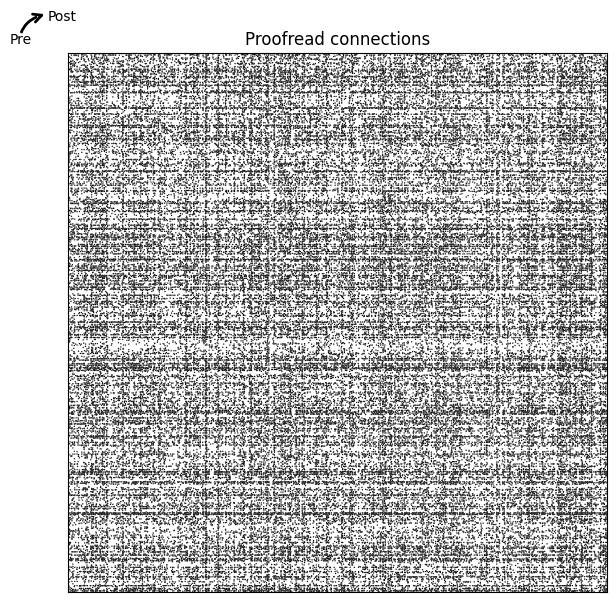

In [19]:
from matrix_plotting import adjacencyplot

fig, ax = plt.subplots(figsize=(7, 7))
ax, grid = adjacencyplot(
    syn_mat,
    ax=ax,
    title="Proofread connections",
)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2:</b> The matrix above only contains connections between proofread neurons. Because many more dendrites of cells in the v1dd dataset are well reconstructed we can analyze many more connections than just the ones between proofread neurons. Therefore, the connectivity matrix of analyzable connections forms a rectangular matrix. What is the size of the matrix between the proofread neurons and all neurons with a cell body in the dataset?
    
</div>

In [20]:
# Select synapses from proofread cells onto all cells
proof_proof_syn_table = filter_synapse_table(
    syn_df, pre_root_ids=axon_proof_root_ids, post_root_ids=dendrite_proof_root_ids
)

rect_syn_mat = make_adjacency(
    syn_df,
    source_cell_index=axon_proof_root_ids,
    target_cell_index=dendrite_proof_root_ids,
)
rect_syn_mat.shape

(1207, 63936)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

How to take synapse size and number into account depends on the specific analysis. The sizes in the MICrONS dataset measure the synaptic cleft volume annotated by the automated classifier in voxels (3d pixels). These are correlated to anatomical measures such as synaptic area and spine head volumes (for excitatory synapses). Let's replot the square matrix with the average of synapses sizes between each connected pair.

</d>

In [21]:
# get the ids of all proofread cells
proof_root_ids = axon_proof_root_ids[
    np.isin(axon_proof_root_ids, dendrite_proof_root_ids)
]
syn_mat = make_adjacency(syn_df, source_cell_index=proof_root_ids, aggfunc="mean")
syn_mat.data

array([2620.,  898., 1276., ...,  846.,  309., 1845.], shape=(90650,))

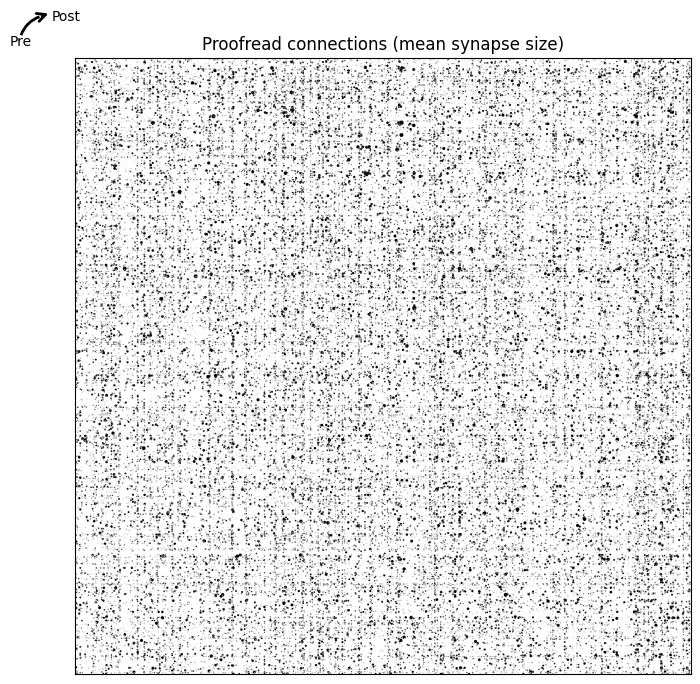

In [22]:
ax, grid = adjacencyplot(
    syn_mat,
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.1, 10),  # set the min and max size of the dots
    hue_norm=(0.3, 1),  # set how to scale colors
    title="Proofread connections (mean synapse size)",
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Depending on the connection type, number of synapses might be the more important measure (see [Dorkenwald et al., 2022](https://elifesciences.org/articles/76120) for deeper dive into synapse size and counts). Next we plot the number of synapses per connection (we limit the colorbar to a maximum of 5 but the actual max number is much higher):


</d>

In [23]:
syn_mat = make_adjacency(syn_df, proof_root_ids, aggfunc=lambda x: np.sum(x > 0))
# show the first 10 nonzero values in the sparse array
syn_mat.data[:10]


array([1, 1, 3, 1, 1, 1, 1, 1, 1, 1])

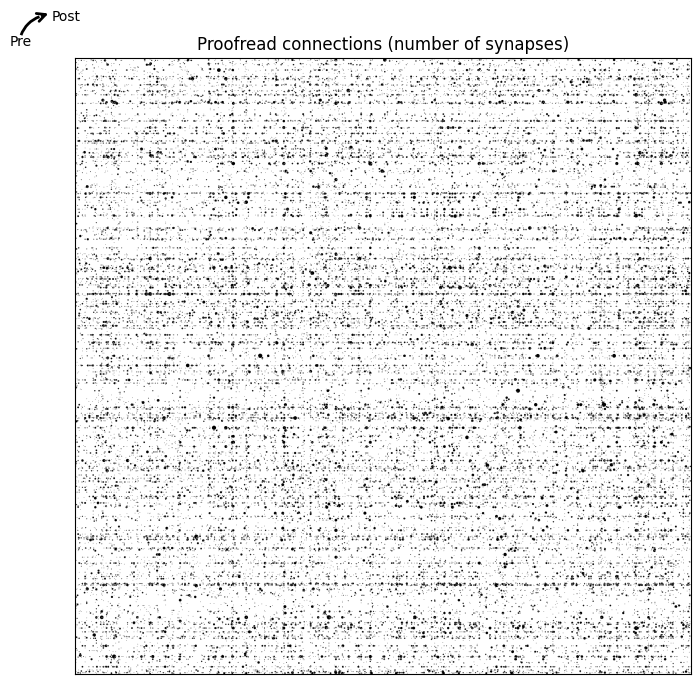

In [24]:
ax, grid = adjacencyplot(
    syn_mat,
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.1, 10),  # set the min and max size of the dots
    hue_norm=(0.3, 1),  # set how to scale colors
    title="Proofread connections (number of synapses)",
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Cell type tables

**NEEDS CHANGING TO V1DD**

Identifying the putative ‘cell type’ from the EM morphology is a process that involves both manual and automatic classifications. Subsets of the dataset have been manually classified by anatomists at the Allen Institute, and these ground truth labels used to train and refine different automated ‘feature classifiers’ over time. 

The diversity of manual and automated cell type classifications available in the dataset reflect the fact that definitions of ‘cell types’ in the dataset is an active area of research and must be contextualized against the purpose and resolution of the cell-typing being performed.

<b> Manual Cell Types (V1 Column)</b>

A subset of nucleus detections in a 100 um column (n=2204) in VISp were manually classified by anatomists at the Allen Institute into categories of cell subclasses, first distinguishing cells into classes of non-neuronal, excitatory and inhibitory. Excitatory cells were separated into laminar sub-classes (L23, L4), 3 sub-types of layer 5 cells (ET, IT, NP) and 2 classes of layer 6 cells (IT, CT). Inhibitory cells were classified into Bipolar (BPC), Basket (BC), Martinotti (MC), or Unsure (Unsure). Those neuronal calls are available from the CAVEclient under the table name `allen_v1_column_types_slanted_ref` which references the nucleus id of the cell, and the column `cell_type_manual` in the prepared data for this workshop. 

Non-neuronal manual cells type calls enumerate astrocytes, microglia, pericytes, oligodendrocytes (oligo), and oligodendrocyte precursor cells (OPC), and area available in the table `aibs_column_nonneuronal_ref`.

<b>Automated Cell Type classification (Soma-nucleus model)</b>

Models were trained based upon the manual Column Neuron labels, as described in <a href=https://www.biorxiv.org/content/10.1101/2022.07.20.499976v1>Elabbady et al. BioRxiv 2023.</a> Each nucleus was analyzed for a variety of features, and a model trained on and independent dataset to distinguish neurons from non-neuronal detections. Non-neuron detections include both glial cells and false positive detections. The nucleus segmentation detected 171,818 connected components of nucleus objects, this model detected 82K neurons. Evaluation of this model on 1,316 cells in the volume shows the model has a recall of 99.6% for neurons, and a precision of 96.9%. All nucleus detections and the results of this model can be queried and linked to the cellular segmentation using the CAVEclient with the table name nucleus_neuron_svm. 

Combining those features with the nucleus features we trained a hierachical model on the manual labels to predict cell-classes and sub-classes across a large number of neurons. This is available as CAVE table `aibs_metamodel_celltypes_v661`, and the column `cell_type_auto` in the prepared data for this workshop.
    
</d>

In [25]:
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

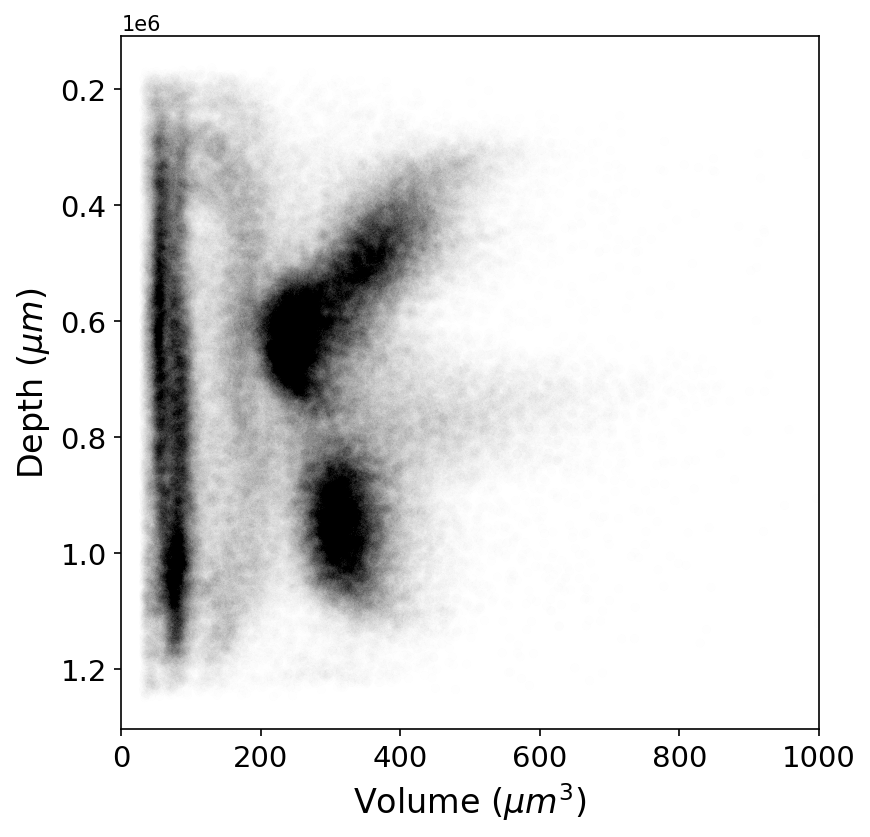

In [26]:
# Plot cell volume by depth
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(
    data=cell_df,
    x="volume",
    y="pt_position_y",
    size=1,
    edgecolor=None,
    alpha=0.005,
    color="k",
    ax=ax,
    legend=False,
)
ax.invert_yaxis()
ax.set_xlabel(r"Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel(r"Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 1000)
plt.show()

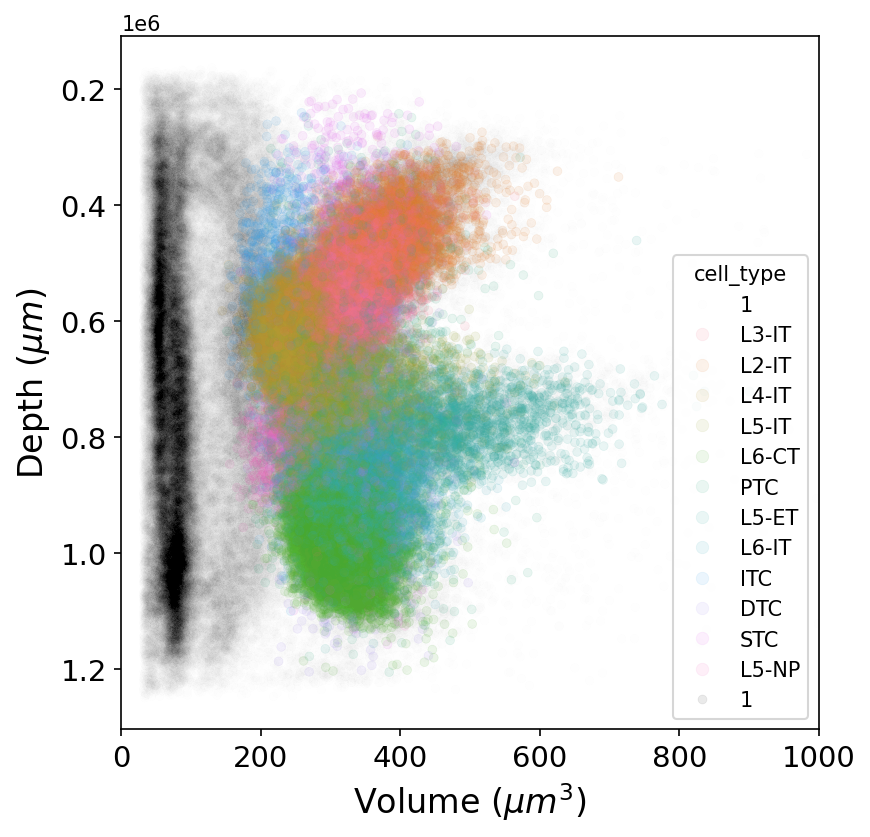

In [27]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(
    data=cell_df,
    x="volume",
    y="pt_position_y",
    size=1,
    edgecolor=None,
    alpha=0.005,
    color="k",
    ax=ax,
    legend=True,
)
sns.scatterplot(
    data=cell_df,
    x="volume",
    y="pt_position_y",
    size=1,
    edgecolor=None,
    alpha=0.1,
    color="k",
    ax=ax,
    legend=True,
    hue="cell_type",
)
ax.invert_yaxis()
ax.set_xlabel(r"Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel(r"Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 1000)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Sorting the synapse matrix with cell types
    
Let's combine the synaptic connecitivity with the cell type information. Below we provide logic for sorting a connectivity matrix using a list of labels.    
    
</d>

In [28]:
proof_root_ids = np.intersect1d(proof_root_ids, cell_df["pt_root_id"].values)
proof_cell_df = cell_df.set_index("pt_root_id").loc[proof_root_ids]
proof_cell_df = proof_cell_df.query("cell_type.notna()")

syn_mat = make_adjacency(syn_df, proof_cell_df, aggfunc="sum")

(<Axes: title={'center': 'Proofread connectivity (sorted by depth)'}>,
 <matrix_plotting.AxisGrid at 0x2c988c3b0>)

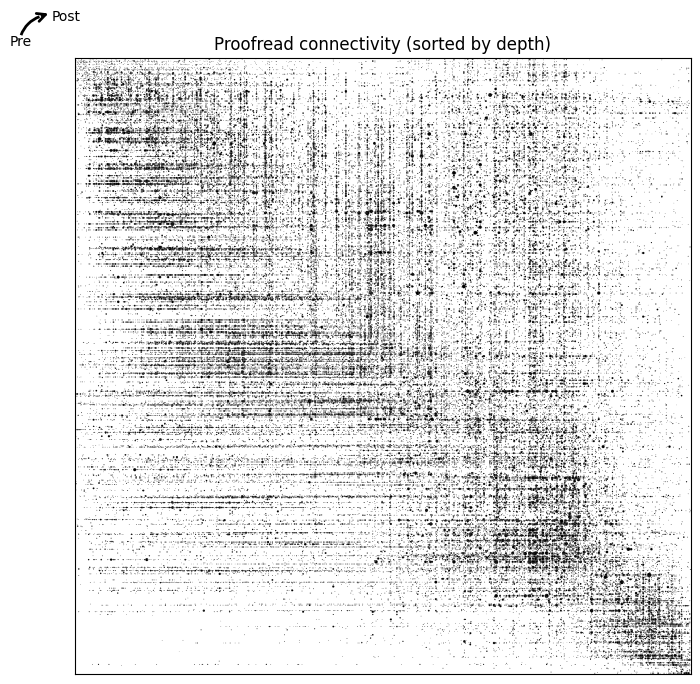

In [32]:
adjplot_kws = dict(
    edge_hue=False,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.1, 10),  # set the min and max size of the dots
    hue_norm=(-1, 1),  # set how to scale colors
)
adjacencyplot(
    syn_mat,
    nodes=proof_cell_df,
    sortby="pt_position_y",
    title="Proofread connectivity (sorted by depth)",
    **adjplot_kws,
)

In [33]:
node_hue = "cell_type"

n_e_classes = len(proof_cell_df.query("cell_type_coarse == 'E'")[node_hue].unique())
n_i_classes = len(proof_cell_df.query("cell_type_coarse == 'I'")[node_hue].unique())

e_colors = sns.cubehelix_palette(
    start=0.4, rot=0.3, light=0.85, hue=1.0, dark=0.4, gamma=1.3, n_colors=n_e_classes
)

i_colors = sns.cubehelix_palette(
    start=0.3, rot=-0.4, light=0.75, dark=0.2, hue=1.0, gamma=1.3, n_colors=n_i_classes
)

cell_type_palette = dict(
    zip(
        proof_cell_df.sort_values(["cell_type_coarse", node_hue])[node_hue].unique(),
        e_colors + i_colors,
    )
)

cell_type_palette["E"] = np.array(list(e_colors)).mean(axis=0)
cell_type_palette["I"] = np.array(list(i_colors)).mean(axis=0)

(<Axes: >, <matrix_plotting.AxisGrid at 0x2a2df7130>)

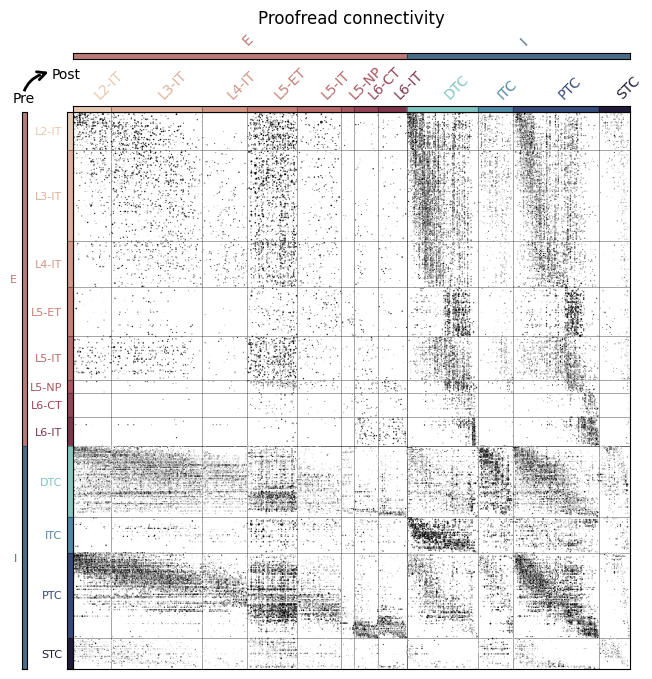

In [34]:
adjplot_kws = dict(
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.5, 5),  # set the min and max size of the dots
    hue_norm=(0, 1),  # set how to scale colors
)
adjacencyplot(
    syn_mat,
    nodes=proof_cell_df,
    groupby=["cell_type_coarse", "cell_type"],
    sortby="pt_position_y",
    node_palette=cell_type_palette,
    title="Proofread connectivity",
    **adjplot_kws,
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Adding connection type

TODO: @bdpedigo
    
</d>